## Using autoencoders to explore common patterns in high-dimensional data.

This tutorial will cover the basics of training a machine learning model using Keras. 
We first show this example in the following steps:

     * Reducing a high-dimensional dataset to be more suitable for machine learning applications using autoencoders.
     * Applying k-means clustering algorithms on the reduced dataset.
     * Exploring what patterns are present in the data.

For this example, we use Doppler lidar data from the DOE Atmospheric Radiation Measurement Southern Great Plains site during August and September 2017. We use a statistical coverage product calculated from the Doppler lidar data that represents the 5-min coverage of various Signal-to-Noise ratio and Doppler velocity thresholds from vertically pointing scans over a two month period. 

In [77]:
import xarray as xr
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

We load our input dataset. This dataset contains 5 minute vertical profiles from the Doppler lidar at the ARM SGP C1 site. For each profile, we have the percent of the time period where the Signal to Noise Ratio is greater than *x* DB, where *x* can be 0.5, 1, 2, and 5 dB.  We also have a similar coverage product for doppler Veloicty, which is the radial vertical velocity of scatterers. In addition, we also obtain a coverage product on the standard deviation of SNR over a 3 x 3 gate window. Higher standard deviations typically represent cloud bases, so the statistical coverage of this product will provide an idea on where cloud base heights are.

In [132]:
my_ds = xr.open_dataset('coverage_and_labels.nc')
my_ds

<xarray.Dataset> Size: 3GB
Dimensions:                     (time: 11805, range: 199, snr_bins: 49,
                                 vel_bins: 79)
Coordinates:
  * time                        (time) datetime64[ns] 94kB 2017-07-31T18:01:1...
  * snr_bins                    (snr_bins) float64 392B 0.0 1.0 ... 47.0 48.0
  * vel_bins                    (vel_bins) float64 632B -20.0 -19.5 ... 19.0
Dimensions without coordinates: range
Data variables: (12/20)
    snrgt0.100000               (time, range) float64 19MB ...
    snr_hist                    (time, range, snr_bins) float64 921MB ...
    vel_hist                    (time, range, vel_bins) float64 1GB ...
    snrgt0.500000               (time, range) float64 19MB ...
    snrgt1.000000               (time, range) float64 19MB ...
    snrgt2.000000               (time, range) float64 19MB ...
    ...                          ...
    stddevgt1.000000            (time, range) float64 19MB ...
    stddevgt2.000000            (time, range) float64 19MB ...
    stddevgt5.000000            (time, range) float64 19MB ...
    Time                        (time) datetime64[ns] 94kB ...
    range_bins                  (time, range) float64 19MB ...
    labels                      (time) int64 94kB ...

## Create autoencoder from % coverage SNR

Dataset for this problem:

We first have to load in the coverage data into a 2D array of *n_samples* by *n_features*. Here, we have 396 features, one for each of the 99 height levels for the four SNR thresholds. We then have to remove completely zero time periods where we have no data. 

Finally, we normalize the data using the *MinMaxScaler* functionality in scikit-learn. This normalizes the input data to where the minimum value is 0 and maximum value is 1.

**Exercise: Change around the input parameters and see how the metrics change.** 

In [239]:
# Select the range in which we want to make the autoencoder
range_ind = np.logical_and(my_ds['range_bins'][0] > 100., my_ds['range_bins'][0] < 3000.)

# Load features into n_samples by n_features array
snr_scp = np.concatenate([my_ds['stddevgt0.100000'].values[:, range_ind],
                          my_ds['stddevgt0.500000'].values[:, range_ind], my_ds['stddevgt1.000000'].values[:, range_ind]], axis=1)

# Convert NaN to 0
snr_scp = np.nan_to_num(snr_scp)

# Remove all zero vertical profiles
gt0 = snr_scp.sum(axis=1) > 0
snr_scp = snr_scp[gt0, :]

# Remove bottom 3 gates since that would be impacted by the ground

# Scale the dataset
scaler = MinMaxScaler()
scaler.fit(snr_scp)
snr_scp_scaled = scaler.transform(snr_scp)

A common technique for dimensionality reduction in machine learning that is useful when the covariance between variables is nonlinear is to use an autoencoder. An autoencoder is a neural network that describes a function $f(x) = x$. In essence, the input is equal to the output. However, the structure is such that the middle layer of the network is an encoding of the input space. Therefore, on the left we have the encoder and on the right we have the decoder.

This is the general structure of an encoder-decoder model.

<img src=https://www.compthree.com/images/blog/ae/ae.png width="600" height="600">

What we are interested in here are the values from the middle layer of the neural network, also known as the latent space. However, we don't know these values without training the whole network including both the encoder and decoder, since all we know is the value of $x$. Therefore, we need to train the complete model first, then when we want just the encodings we will remove the decoder layers and then predict the encodings from the trained encoder model.

Once we have the encoder to produce the latent space, then it becomes more feasible to use clustering techniques on the data to learn about how your dataset is grouped together.

In [245]:
def model(input_ds):
    inp = Input(shape=(input_ds.shape[1],), name='input')
    
    layer1 = Dense(64, activation='relu', name='EncDense')(inp)
    encoding = Dense(10, name='code')(layer1)
    layer1_dec = Dense(64, activation='relu', name='DecDense')(encoding)
    decoding = Dense(input_ds.shape[1], name='output')(layer1_dec)
    
    autoencoder = Model(inp, decoding)
    return autoencoder

In this example above, I am reducing the 597 dimensional input to a 10-dimensional latent space. I am doing this by using a single fully-connected layer with 64 nodes on both the encoder and decoder. The encoder then uses this fully connected-layer to map the inputs to a 10-dimensional space. The decoder maps the 10-dimensional latent space back to the input features using a fully-connected layer with 64 nodes.

**Exercise: See how the training metrics change as you change the number of nodes in the fully connected layer.**

In [246]:
autoencoder = model(snr_scp_scaled)
autoencoder.summary()

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EncDense (Dense)                │ (None, 64)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ code (Dense)                    │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DecDense (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 144)            │         9,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,994 (78.10 KB)

 Trainable params: 19,994 (78.10 KB)

 Non-trainable params: 0 (0.00 B)

Now, we compile the model. For this model, we are going to choose

In [247]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In order to evaluate the performance of our model,

First, we split the dataset into two categories: 

* A training dataset that is used to train the model. Commonly, about 75-80% of the dataset is chosen at random for training.
* A testing dataset that comprises of what was not chosen for training. This dataset is used to evaluate the model performance after training.

The accuracy of the trained model can be highly dependent on the chosen data. A common way to determine how sensisitive the training is to the random selection of the dataset is to use a technique called $k$-fold cross validation. What this technique does is split the training dataset into $k$ randomly chosen folds. $1/k$ of the dataset is randomly chosen for testing, and the remainder for training. The below line of code will demonstate how the dataset is split for these given folds. The training data are in blue, and the testing data are shown in red.

Text(0, 0.5, 'Split #')

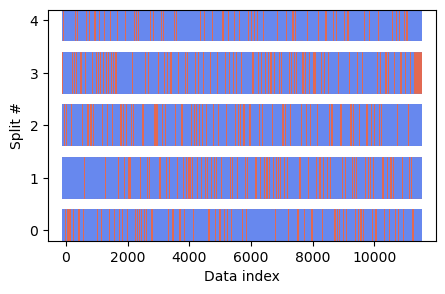

In [248]:
kfold = KFold(n_splits=5, shuffle=True)
plt.figure(figsize=(5, 3))
for i, (train, test) in enumerate(kfold.split(snr_scp_scaled, snr_scp_scaled)):
    indices = np.array([np.nan] * snr_scp_scaled.shape[0])
    indices[test] = 1
    indices[train] = 0

    plt.scatter(
            range(len(indices)),
            [i ] * len(indices),
            c=indices,
            marker="_",
            lw=30,
            cmap='coolwarm',
            vmin=-0.2,
            vmax=1.2,
        )
plt.yticks([0, 1, 2, 3, 4])
plt.xlabel('Data index')
plt.ylabel('Split #')

Using the training and testing splits above, let's train each version of the m

In [250]:
kfold = KFold(n_splits=5, shuffle=True)
loss_per_fold = []
no_epochs = 40
history_per_fold = []
models = []
fold_no = 1
for train, test in kfold.split(snr_scp_scaled, snr_scp_scaled):
    autoencoder = model(snr_scp)
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    history = autoencoder.fit(snr_scp_scaled[train], snr_scp_scaled[train], epochs=no_epochs, validation_data=(snr_scp_scaled[test], snr_scp_scaled[test]))
    scores = autoencoder.evaluate(snr_scp_scaled[test], snr_scp_scaled[test], verbose=0)
    print(f'Score for fold {fold_no}: {autoencoder.metrics_names[0]} of {scores}')
    loss_per_fold.append(scores)
    history_per_fold.append(history)
    models.append(autoencoder)
    fold_no += 1

Epoch 1/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0202 - val_loss: 0.0058
Epoch 2/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 3/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 4/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 5/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 6/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 11/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Let's plot the loss and validation loss for each fold. This is important for assessing whether our model is a good fit for the data. With machine learning models, there is a danger of either underfitting or overfitting to the training data. Commonly, overfitting occurs when the training loss is very low, but the dataset makes poor predictions on the validation dataset.  

* **Overfitting**: The training loss decreases while the validation loss increases with the number of training epochs.
* **Underfitting**: Neither the training nor validation loss decrease with number of training epochs.
* **Ideal**: Both the training and validation loss decrease with the number of epochs.

In this example, the training and validation loss decrease together quite nicely, showing that we are not overfitting.

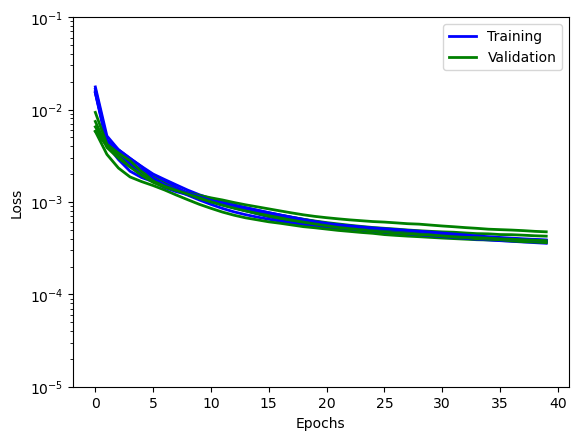

327/327 [==============================] - 2s 6ms/step - loss: 0.5165
Epoch 387/1000
327/327 [==============================] - 2s 6ms/step - loss: 0.5212
Epoch 388/1000
327/327 [==============================] - 2s 5ms/step - loss: 0.5034
Epoch 389/1000
327/327 [==============================] - 1s 3ms/step - loss: 0.4979
Epoch 390/1000
327/327 [==============================] - 0s 892us/step - loss: 0.4965
Epoch 391/1000
327/327 [==============================] - 0s 887us/step - loss: 0.4999
Epoch 392/1000
327/327 [==============================] - 0s 888us/step - loss: 0.5178
Epoch 393/1000
327/327 [==============================] - 0s 889us/step - loss: 0.5058
Epoch 394/1000
327/327 [==============================] - 0s 885us/step - loss: 0.4969
Epoch 395/1000
327/327 [==============================] - 1s 3ms/step - loss: 0.4940
Epoch 396/1000
327/327 [==============================] - 2s 5ms/step - loss: 0.4969
Epoch 397/1000
327/327 [==============================] - 2s 5ms/step 

327/327 [==============================] - 2s 5ms/step - loss: 0.4864
Epoch 483/1000
327/327 [==============================] - 2s 5ms/step - loss: 0.4752
Epoch 484/1000
327/327 [==============================] - 2s 6ms/step - loss: 0.4915
Epoch 485/1000
327/327 [==============================] - 1s 4ms/step - loss: 0.5071
Epoch 486/1000
327/327 [==============================] - 0s 966us/step - loss: 0.4998
Epoch 487/1000
327/327 [==============================] - 0s 945us/step - loss: 0.4637
Epoch 488/1000
327/327 [==============================] - 0s 943us/step - loss: 0.4666
Epoch 489/1000
327/327 [==============================] - 0s 952us/step - loss: 0.4879
Epoch 490/1000
327/327 [==============================] - 0s 959us/step - loss: 0.4797
Epoch 491/1000
327/327 [==============================] - 2s 5ms/step - loss: 0.4680
Epoch 492/1000
 89/327 [=======>......................] - ETA: 1s - loss: 0.5100

KeyboardInterrupt: 

In [251]:
plt.plot(history_per_fold[0].history['loss'], color='b', linewidth=2, label='Training')
plt.plot(history_per_fold[0].history['val_loss'], color='g', linewidth=2, label='Validation')
for i in range(1, 5):
    plt.plot(history_per_fold[i].history['loss'], color='b', linewidth=2)
    plt.plot(history_per_fold[i].history['val_loss'], color='g', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim([1e-5, 1e-1])
plt.legend()

The encoder part is made by removing the decoder portion from the model.

In [252]:
encoder = Model(autoencoder.input, autoencoder.get_layer('code').output)

In [253]:
encoder.summary()

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EncDense (Dense)                │ (None, 64)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ code (Dense)                    │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,930 (38.79 KB)

 Trainable params: 9,930 (38.79 KB)

 Non-trainable params: 0 (0.00 B)

In [254]:
out_encodings = encoder.predict(snr_scp)

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


Now that we have a dataset with reduced dimensionality that we can use more easily with machine learning techniques, the rest of this tutorial will demonstrate a basic example of how to cluster the data. We will use $k$-means clustering. This is done by first specifying the number of clusters. Then, the centroid of each cluster $S_{i}$, $\mu_{i}$ that minimizes the objective function below is found:

$ O = \Sigma_{S_i} ||x - \mu_i||$

Essentially, the points are assigned to each cluster such that the mean squared error of the distance between each point and its centroid over the cluster is minimized.

The number of clusters must be assigned by the user in advance. The question here then remains, how many clusters do we choose? One common method to determine the optimal number of clusters in your dataset is the "elbow technique." To perform the elbow technique, you plot the SSE as a function of number of clusters. 

In [255]:
SSE = np.zeros(15)

for i in range(1, 16):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(out_encodings)
    SSE[i-1] = kmeans.inertia_

One common method to determine the optimal number of clusters in your dataset is the "elbow technique." To perform the elbow technique, you plot the SSE as a function of number of clusters. You should get a plot that resembles exponential decay. In this example, I would place the elbow of the plot anywhere from two to six clusters. This shows that even objective techniques for choosing the number of clusters do not always give a clear answer. Therefore, it is up to the domain scientist to determine what number of clusters best separates the patterns that they are looking for.

Text(0, 0.5, 'Total squared error')

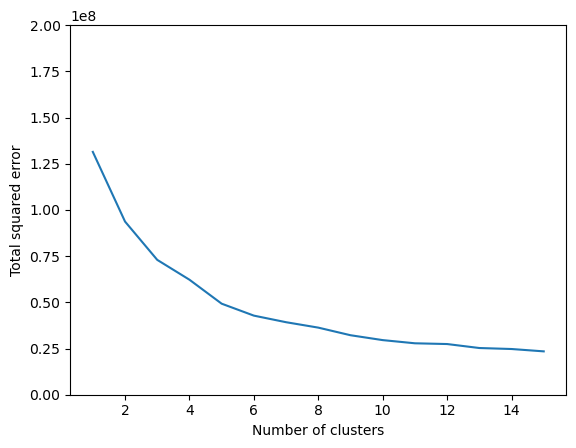

In [259]:
plt.plot(range(1, 16), SSE)
plt.ylim([0, 2e8])
plt.xlabel('Number of clusters')
plt.ylabel('Total squared error')

In [266]:
num_classes = 5
kmeans = KMeans(n_clusters=num_classes)
kmeans.fit(out_encodings)
classes = kmeans.predict(out_encodings)

Let's plot out what the clusters mean! One thing you want to ensure while doing this is that the clusters are physically meaningful in some way. Otherwise, it's neat to do machine learning, but machine learning without physical interpretability is useless.

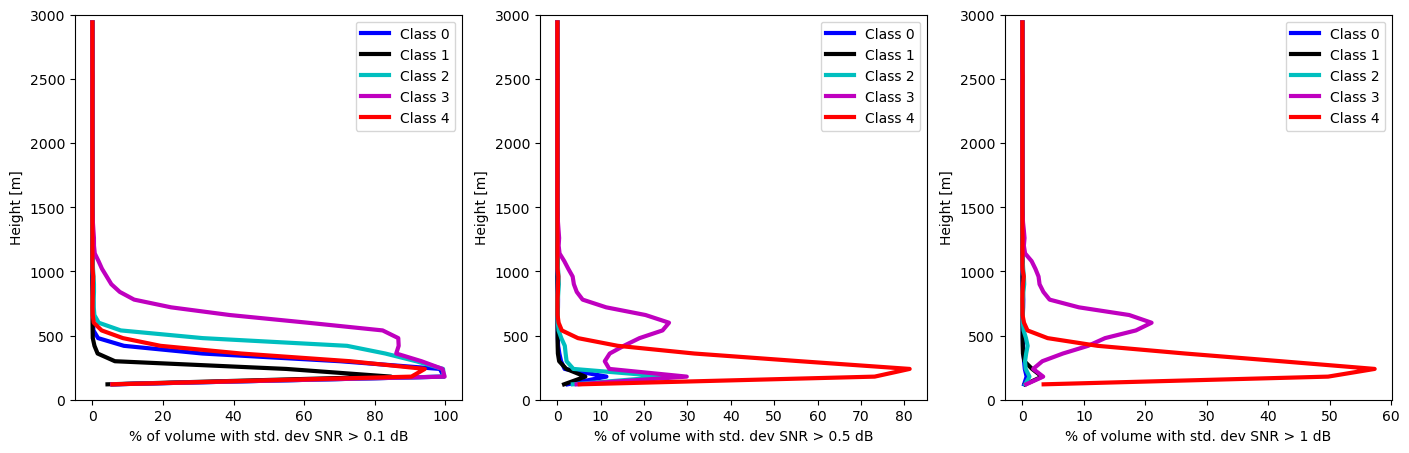

In [269]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
colors = ['b', 'k', 'c', 'm', 'r']
for i in range(num_classes):
    ax[0].plot(np.nanmean(snr_scp[classes == i, :48], axis=0), my_ds.range_bins[0,range_ind], label='Class %d' % i, 
               linewidth=3, color=colors[i])
    ax[0].legend()
    ax[0].set_xlabel('% of volume with std. dev SNR > 0.1 dB')
    ax[0].set_ylabel('Height [m]')
    ax[0].set_ylim([0, 3000])

for i in range(num_classes):
    ax[1].plot(np.nanmean(snr_scp[classes == i, 48:96], axis=0), my_ds.range_bins[0,range_ind], label='Class %d' % i, 
               linewidth=3, color=colors[i])
    ax[1].legend()
    ax[1].set_xlabel('% of volume with std. dev SNR > 0.5 dB')
    ax[1].set_ylabel('Height [m]')
    ax[1].set_ylim([0, 3000])


for i in range(num_classes):
    ax[2].plot(np.nanmean(snr_scp[classes == i, 96:], axis=0), my_ds.range_bins[0,range_ind], label='Class %d' % i, 
               linewidth=3, color=colors[i])
    ax[2].legend()
    ax[2].set_xlabel('% of volume with std. dev SNR > 1 dB')
    ax[2].set_ylabel('Height [m]')
    ax[2].set_ylim([0, 3000])

The clustering of cloud base heights that are visible in the lidar data is most apparent when looking at the middle panel above. We can see that Class 4 represents time periods with low stratus present over the SGP. Meanwhile, Class 3 shows times with cloud bases around 0.75 km. Classes 0 to 2 generally have lower SNR textures near the surface, showing more scattered clouds and clearer air conditions. 

**Exercise: Play around with the number of clusters to see how the answers change!**

In [127]:
my_ds.range_bins

<xarray.DataArray 'range_bins' (time: 11805, range: 199)> Size: 19MB
array([[    0.,    60.,   120., ..., 11760., 11820., 11880.],
       [    0.,    60.,   120., ..., 11760., 11820., 11880.],
       [    0.,    60.,   120., ..., 11760., 11820., 11880.],
       ...,
       [    0.,    60.,   120., ..., 11760., 11820., 11880.],
       [    0.,    60.,   120., ..., 11760., 11820., 11880.],
       [    0.,    60.,   120., ..., 11760., 11820., 11880.]])
Coordinates:
  * time     (time) datetime64[ns] 94kB 2017-07-31T18:01:14.540000 ... 2017-0...
Dimensions without coordinates: range